# 삼성 DS-KAIST AI Expert 프로그램
## Week 3: Autoencoder, VAE, GAN

실습 일시: 2019년 7월 19일 (금), 13:30 - 17:30

담당 조교: 박종진 (pjj4288@kaist.ac.kr)

## Introduction

본 실습에서는 TensorFlow 프레임워크를 이용해 강의에서 소개된 Variational Autoencoder (VAE), Generative Adversarial Networks (GAN)을 구현해 보는 것을 목표로 합니다. 실습은 크게 2개의 파트로 구성됩니다: 첫 번째 파트에서는, 얕은 합성곱 신경망 (CNN)으로 구성된 VAE를 구현하고 그 목적 함수인 evidence lower bound (ELBO)와 이를 학습 가능하게 해주는 reparameterization trick을 이해할 것입니다. 두 번째 파트에서는, 좀 더 깊은 신경망으로 구성된 GAN (DCGAN)을 학습하고 이를 통해 GAN의 목적 함수와 최적화 방법을 이해할 것입니다.

In [1]:
# 실습에서 사용할 모듈을 import 합니다.

# IPYthon 상에서 matplotlib 라이브러리가 
# 별도의 창 없이 즉시 plot을 출력할 수 있도록 설정을 변경합니다.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import time

# "즉시 실행" (eager execution) 기능을 활성화합니다.
# 즉시 실행 활성화로 TensorFlow를 대화형 프론트엔드(frontend)에 가깝게 만들어 줍니다.
# 해당 기능은 TensorFlow 2.0 부터는 기본적으로 활성화됩니다. 
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Eager execution: True


## Part 0: 데이터셋 로드 및 전처리

본 실습의 Part 1,2에서는 강의에서 다룬 다층신경망을 활용하여 운동화나 셔츠 같은 옷 이미지를 생성하는 모델을 만들어볼 것입니다. 10개의 클래스와 70,000개의 흑백 이미지로 구성된 Fashion-MNIST 데이터셋을 사용하여 이를 생성하는 컨볼루션 신경망 모델을 구성하고 학습한 뒤, 그 결과를 확인합니다. 이전 실습에서 다루었지만 복습 차원에서 어떤 데이터셋인지 다시 한 번 확인해볼 것입니다.

In [2]:
# 실습 과정에서 사용되는 도움함수를 정의합니다. 

def visualize_dataset(images, labels, class_names=None, cmap=plt.cm.binary):
    """데이터셋을 간략히 시각화함"""
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=cmap)
        if class_names:
            plt.xlabel(class_names[labels[i]])
        else:
            plt.xlabel("Label: {}".format(labels[i]))
    plt.show()

In [3]:
# Fashion-MNIST 데이터셋은 TensorFlow에서 바로 불러올 수 있습니다.
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 각 데이터 샘플은 0~9 사이의 값을 라벨로 가지고, 각 라벨과 실제 대응되는 옷 종류는 아래와 같습니다.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 불러온 데이터셋은 0~255 사이의 값을 가지는 흑백 이미지로 구성되어 있습니다.
# 네트워크의 안정적인 학습을 위해, 각 데이터가 0~1 사이의 값을 가지도록 전처리합니다.
# 이때, 훈련 데이터셋과 테스트 데이터셋을 같은 방식으로 전처리해주는 것이 중요합니다.
train_images = train_images / 255.0
test_images = test_images / 255.0

print('훈련 세트 수: {}'.format(len(train_labels)))
print('테스트 세트 수: {}'.format(len(test_labels)))
print('이미지 크기: %d x %d' % train_images.shape[1:])
print('레이블 형태: {}'.format(train_labels))


훈련 세트 수: 60000
테스트 세트 수: 10000
이미지 크기: 28 x 28
레이블 형태: [9 0 0 ... 3 0 5]


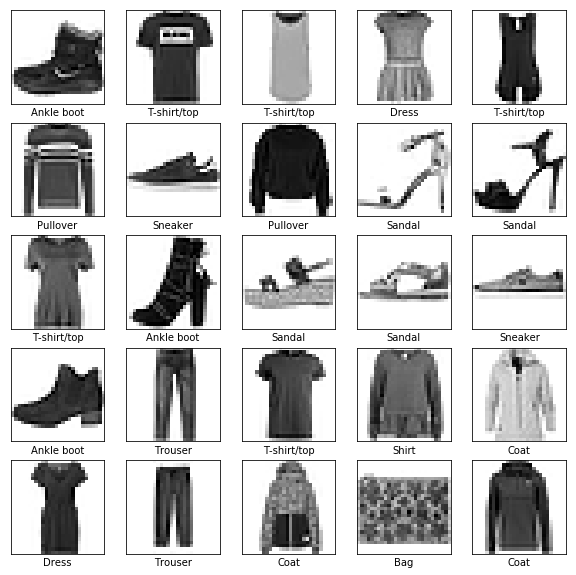

In [4]:
# 불러온 Fashion-MNIST 데이터셋을 간략히 시각화합니다.
visualize_dataset(train_images, train_labels, class_names)

### VAE와 GAN을 위한 이미지 전처리

이미지 생성 모델을 제대로 학습하기 위해서는 전처리 과정도 짚고 넘어갈 필요가 있습니다. VAE의 경우 likelihood p(x|z)를 어떻게 디자인하냐에 따라 다르게 처리해줄 필요가 있고, GAN의 경우 특별한 제약은 없지만 generator의 마지막 activation function의 선택에 맞춰주어야 합니다.
본 실습에서는 p(x|z)를 multivariate Bernoulli distribution 이라고 가정할 것이므로 VAE를 위한 전처리는 binarization (0 또는 1)이 됩니다. 또한 GAN의 generator가 tanh function을 activation으로 사용할 것이므로 GAN을 위한 전처리는 [-1, 1]로 normalize하는 것입니다.

In [5]:
# GAN을 위한 전처리 과정.
# generator의 마지막 activation function에 따라 전처리 과정이 달라집니다. 이번 실습에서는 tanh function을 사용하므로 [-1, 1] 범위로 normalize해줍니다.
train_images_gan = (train_images*2.) - 1. # Normalize the images from [0, 1] to [-1, 1]
test_images_gan = (test_images*2.) - 1. # Normalize the images from [0, 1] to [-1, 1]

In [6]:
# VAE를 위한 전처리 과정.
# p(x|z)가 multivariate Bernoulli distribution이라고 가정할 경우 x는 binary data가 됩니다.
# Binarization을 위한 전처리 과정은 다음과 같습니다.
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

train_images_vae = train_images
test_images_vae = test_images

In [7]:
# CNN을 input을 위한 이미지 reshape
train_images_gan = train_images_gan.reshape(train_images_gan.shape[0], 28, 28, 1).astype('float32')
test_images_gan = test_images_gan.reshape(test_images_gan.shape[0], 28, 28, 1).astype('float32')
train_images_vae = train_images_vae.reshape(train_images_vae.shape[0], 28, 28, 1).astype('float32')
test_images_vae = test_images_vae.reshape(test_images_vae.shape[0], 28, 28, 1).astype('float32')

In [8]:
# 이미지, 라벨은 각각 numpy.array의 형태로 임포트됩니다.
# 효과적인 학습 구성을 위헤, 1) 이미지, 라벨 쌍을 배치 형태로 묶는 것과 2) 각 배치를 tf.tensor로 변환하는 과정을 수행합니다.
# 이 과정은 tf.data.Dataset 높은 수준의 class를 통해서 쉽게 처리될 수 있습니다.
train_ds_vae = tf.data.Dataset.from_tensor_slices((train_images_vae, train_labels)).shuffle(60000).batch(64)
test_ds_vae = tf.data.Dataset.from_tensor_slices((test_images_vae, test_labels)).batch(64)

train_ds_gan = tf.data.Dataset.from_tensor_slices((train_images_gan, train_labels)).shuffle(60000).batch(64)
test_ds_gan = tf.data.Dataset.from_tensor_slices((test_images_gan, test_labels)).batch(64)

### 생성 모델을 위한 신경망 구성

TensorFlow의 고수준 인터페이스 구현체인 `tf.keras`를 통해서 쉽게 모델을 정의할 수 있습니다. 아래 정의된 모든 layer들은 `tf.keras`에서 제공되는 연산으로만 구성되었습니다:
* `keras.Sequential`([doc](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)): 연속된 레이어를 가진 네트워크를 표현합니다.
* `keras.layers.Flatten`([doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)): Fashion-MNIST의 이미지는 28x28의 행렬 형태입니다. 선형 연산을 하기 위해, 해당 이미지를 1차원 텐서의 형태로 변환합니다. 
* `keras.layers.Dense`([doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)): 입력에 `x` 대한 선형 변환을 수행합니다: `Wx+b`. (W, b)를 파라미터로 갖고, 이들 파라미터는 훈련 도중에 학습됩니다. Fully-connected Layer라고도 불립니다. 
* `keras.layers.Conv2D`([doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)): 입력에 `x` 대한 합성곱 연산을 수행합니다: (W, b)를 파라미터로 갖고, 이들 파라미터는 훈련 도중에 학습됩니다. 주로 feature의 spatial size를 줄일 때 사용합니다. (encoder of VAE, discriminator of GAN)
* `keras.layers.Conv2DTranspose`([doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)): 입력에 `x` 대한 변환 합성곱 연산을 수행합니다: (W, b)를 파라미터로 갖고, 이들 파라미터는 훈련 도중에 학습됩니다. Deconvolution라고도 불립니다. 주로 feature의 spatial size를 늘일 때 사용합니다. (decoder of VAE, generator of GAN)
* `activation=tf.nn.xxxxx`: 각각의 레이어 연산 이후 activation function을 통과합니다. (e.g. tf.nn.softmax)

`model.summary()`를 통해서 구성된 모델을 시각화하고, 총 몇 개의 파라미터가 사용되었는지 (`Total params`), 그 중 학습가능한 파라미터는 몇 개인지 (`Trainable params`) 등을 한 눈에 파악할 수 있습니다.

* Convolution 연산 예시
<img src="resource/conv2d.gif">
* Transposed Convolutoin 연산 예시
<img src="resource/conv2d_transposed.gif">

### 컨볼루션 신경망 모델

컨볼루션 신경망 모델은 `tf.keras`를 통해 쉽게 구성될 수 있습니다. 아래 예시로 주어진 VAE의 인코더 `inference_net`은 2개의 Convolution 레이어와 1개의 Dense 레이어를 가지고 있습니다. 
`Conv2D` 레이어는 3차원 형태로 연산을 수행합니다: `(height, width, channel)`. 단, 마지막 `Dense` 레이어 직전에는 `Flatten()`을 통해 1차원 형태로 변환해줍니다.
실제로 학습을 수행하여, 이미지가 제대로 생성되는지 확인해 보세요.

## Part 1: Variational Autoencoder (VAE) 학습

본 실습의 Part 1에서는 강의에서 다룬 VAE를 구현하여 Fashion-MNIST 데이터셋을 생성하는 컨볼루션 신경망 모델을 구성하고 학습합니다. 그 과정에서 VAE의 핵심인 evidence lower bound (ELBO)와 reparameterization trick에 대한 이해를 깊게 하는 것이 목적입니다.

In [9]:
latent_dim = 50
epochs = 10
num_examples_to_generate = 25

In [10]:
inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )
generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )
print("===== Encoder =====")
inference_net.summary()
print("===== Decoder =====")
generative_net.summary()

===== Encoder =====
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               230500    
Total params: 249,316
Trainable params: 249,316
Non-trainable params: 0
_________________________________________________________________
===== Decoder =====
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)             

### Q1-1. Reparameterization Trick

아래에 VAE가 정의되어 있습니다. encoder/decoder 모델의 구조는 위에서 정의한 것과 같습니다. 강의에서 배우신 바와 같이, VAE를 back propagation으로 학습하기 위해서는 reparameterization trick이 필요합니다. 미완성된 `reparameterize()`함수를 완성해주세요. 함수의 인자로는 `mean (평균)`, `logvar (분산의 log값)`을 받습니다.

* Reparameterization Trick 개요.
<img src="resource/reparam_trick.png">

In [11]:
class VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = inference_net
    self.generative_net = generative_net

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

  def reparameterize(self, mean, logvar):
    """Reparameterization trick"""
    ##### 여기에 코드를 작성하세요 #####
    eps = tf.random.normal(shape=mean.shape)
    z = eps * tf.exp(logvar * .5) + mean
    return z

### VAE 신경망 모델

이제 구성된 `VAE`의 `inference_net (encoder)`와 `generative_net(decoder)`를 사용할 수 있습니다. `tf.keras`는 훈련 과정에 대해서도 매우 높은 수준의 API를 제공하지만, 여기서는 해당 API를 사용하는 대신 우선 학습의 세부적인 과정을 하나씩 살펴보도록 하겠습니다. 아래 코드를 대략적으로 요약하면 다음과 같습니다:
* `compute_loss()` 함수를 통해 모델의 손실 함수 (loss function)을 계산합니다. (미구현)
* `compute_gradients()` 함수를 통해 모델의 그래디언트 (gradient)를 계산합니다.
* `apply_gradients()` 함수를 통해 optimizer가 계산된 그래디언트를 통해 모델을 업데이트합니다.
* `optimizer`는 계산된 그래디언트를 업데이트에 적용하는 방식을 설정하고 수행합니다.

분류기 (classifier)와는 다르게, 생성 모델에서는 모델의 성능을 정확히 평가할 수 있는 방법이 존재하지 않거나 (GAN), 근사값인 경우 (VAE)가 있습니다. VAE의 경우 손실함수 (-ELBO)를 통해 성능을 알 수 있으므로, 학습 과정 중에 이를 확인해보도록 합니다.

### Q1-2. Evidence Lower BOund (ELBO)

이제 필요한 모든 것이 갖춰졌으므로 VAE를 학습할 차례입니다. 강의에서 배우신 바와 같이, VAE는 evidence lower bound (ELBO)를 최대화하도록 학습됩니다. 따라서 손실 함수는 ELBO의 negative값인 -ELBO가 됩니다.

(Hint)

먼저 KL-divergence 항을 Gaussian distribution q(z|x), p(z)에 대해 계산해주면 다음과 같습니다.
* VAE 손실함수.
<img src="resource/loss_vae.png">

likelihood p(x|z)를 multivariate Bernoulli distribution으로 가정하였으므로 reconstruction loss는 다음과 같습니다.
* Reconstruction loss.
<img src="resource/kl_vae.png">

In [12]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  """VAE의 loss 함수 계산."""
  ##### 여기에 코드를 작성하세요 #####
  # Reconstruction loss
  recon_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  recon_loss = tf.reduce_sum(recon_loss, axis=[1, 2, 3])
  # KL Divergence loss
  kl_div_loss = 1 + logvar - tf.square(mean) - tf.exp(logvar)
  kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
  loss = tf.reduce_mean(recon_loss + kl_div_loss)
    
  return loss

In [13]:
def compute_gradients(model, x):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
  optimizer.apply_gradients(zip(gradients, variables))

In [14]:
# 생성된 샘플 이미지들을 plot.
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(5,5))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('VAE_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [15]:
# generation quality 향상을 보기 위한 random vector constant.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

# model과 optimizer 선언
model = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

### VAE 학습 과정 확인

이제 구성된 `VAE`의 `inference_net (encoder)`와 `generative_net(decoder)`를 학습할 수 있습니다. 학습과정은 아래와 같으며, 각 epoch이 끝날 때마다 생성 이미지를 확인할 수 있도록 했습니다. 훈련 예상시간은 약 10분입니다. 진행되는 동안 VAE를 복습하셔도 되고, 아래로 넘어가 GAN에 대한 내용을 진행하셔도 좋습니다.

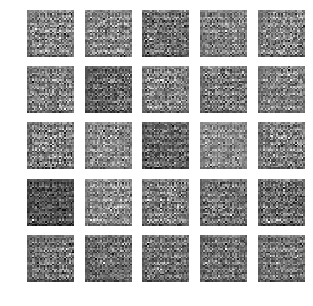

W0719 10:33:12.804406 140048442267392 deprecation.py:323] From /home/jongjin/.local/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1, Test set ELBO: -196.17291259765625, time elapse for current epoch 28.259005308151245


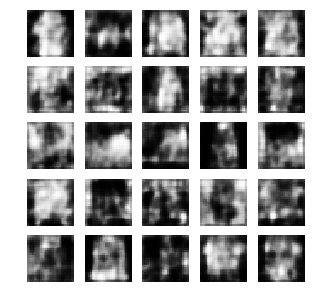

Epoch: 2, Test set ELBO: -170.61196899414062, time elapse for current epoch 27.283297538757324


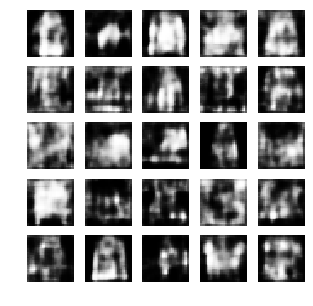

Epoch: 3, Test set ELBO: -159.81532287597656, time elapse for current epoch 27.60321068763733


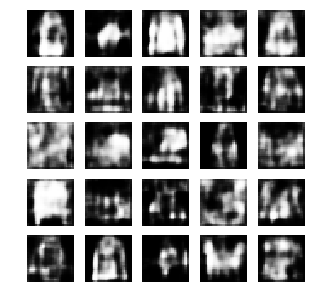

Epoch: 4, Test set ELBO: -154.28993225097656, time elapse for current epoch 28.52913236618042


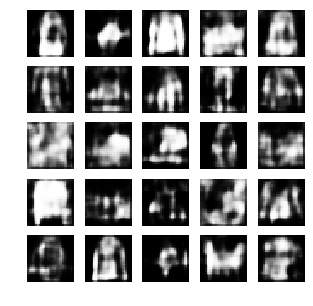

Epoch: 5, Test set ELBO: -149.63755798339844, time elapse for current epoch 28.038700819015503


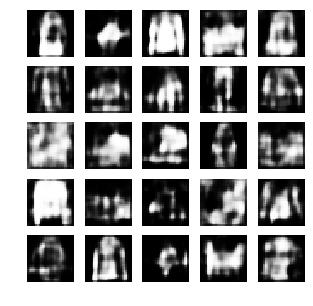

Epoch: 6, Test set ELBO: -146.6608428955078, time elapse for current epoch 27.56920051574707


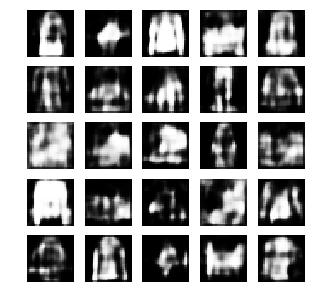

Epoch: 7, Test set ELBO: -144.22300720214844, time elapse for current epoch 27.937352418899536


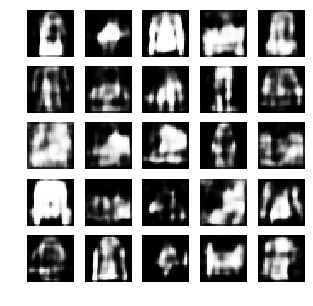

Epoch: 8, Test set ELBO: -141.91485595703125, time elapse for current epoch 27.28878951072693


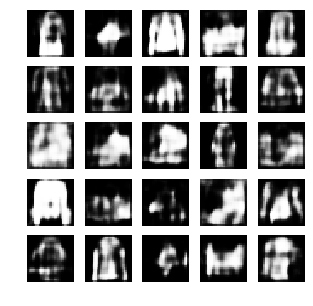

Epoch: 9, Test set ELBO: -140.34512329101562, time elapse for current epoch 25.903283834457397


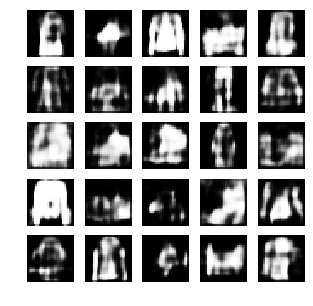

Epoch: 10, Test set ELBO: -139.18173217773438, time elapse for current epoch 27.2926983833313


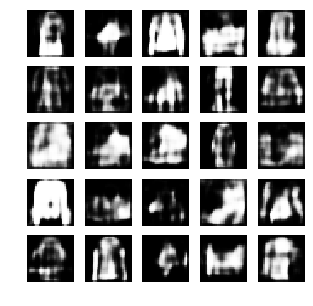

In [16]:
generate_and_save_images(model, 0, random_vector_for_generation)

#학습 시작
for epoch in range(1, epochs + 1):
  start_time = time.time()
  # epoch 시작
  for train_x, _ in train_ds_vae:
    gradients, loss = compute_gradients(model, train_x)
    apply_gradients(optimizer, gradients, model.trainable_variables)
  end_time = time.time()
  # epoch 끝

  if epoch % 1 == 0:
    # test set에서의 ELBO (-loss) 값 확인
    loss = tf.keras.metrics.Mean()
    for test_x, _ in test_ds_vae:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

## Part 2: Generative Adversarial Networks (GAN) 학습

본 실습의 Part 2에서는 강의에서 다룬 GAN을 구현하여 (VAE와 마찬가지로) Fashion-MNIST 데이터셋을 생성하는 컨볼루션 신경망 모델을 구성하고 학습합니다. 그 과정에서 GAN의 objective와 이것이 무엇을 최적화하는지, 그리고 실제 학습이 어떤 방식으로 이루어지는지 이론과의 차이점을 파악하는 것이 목적입니다. Part 2에서는 더 깊게 신경망을 쌓아 성능을 향상시킨 Deep Convolutional GAN (DCGAN)을 사용하게 될 것입니다.

In [16]:
from tensorflow.keras import layers

In [17]:
def generate_and_save_images_gan(model, epoch, test_input):
  gen_images = model(test_input)
  gen_images = gen_images/2 + 0.5 # Normalize the images from [-1, 1] to [0, 1]

  fig = plt.figure(figsize=(5,5))

  for i in range(gen_images.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(gen_images[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('GAN_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Deep Convolutional GAN (DCGAN)

DCGAN의 구조적 특징은 다음과 같습니다. 각각의 특성들은 학습을 안정화시켜 결과적으로 생성 능력을 향상시킵니다.
* 각각 `Conv2DTranspose` / `Conv2D` layer를 generator / discriminator에 사용. 
* 각각 `ReLU` / `LeakyReLU` 함수를 generator / discriminator의 activation으로 사용. 이 때, LeakyReLU의 기울기 (slope)는 0.2. 
* `BatchNormalizaiton` 을 generator / discriminator 둘 모두에 사용.

아래에 DCGAN architecture를 사용한 generator / discriminator가 구현되어 있습니다. 각 layer를 통과할 때마다 output tensor의 크기가 어떻게 변하는지 생각해보세요.

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1], use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, use_bias=False))

    return model

In [20]:
generator = make_generator_model()
discriminator = make_discriminator_model()

print("===== Generator =====")
generator.summary()
print("===== Discriminator =====")
discriminator.summary()

===== Generator =====
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (No

### Q2-1. GAN Loss & Training

본래 GAN의 목표는 다음과 같습니다.
* GAN의 objective.
<img src="resource/gan_obj.png">

강의에서 배우신 바와 같이, GAN을 학습할 때는 generator와 discriminator를 번갈아가며 학습하며, generator에 더 강한 gradient를 주기 위해 실제로는 다음과 같은 loss를 학습합니다. 
* Discrimiantor의 objective.
<img src="resource/dis_loss.png">
* Generator의 objective.
<img src="resource/gen_loss.png">

2-1. 이제 아래 주어진 binary cross entropy 함수를 사용하여 discriminator와 generator의 loss를 계산해보세요. loss는 학습하면서 줄여야 할 대상인 것에 유의하세요.

   구현한 손실 함수를 이용하여 GAN의 training step을 완성하세요. gradient 계산부터는 이미 구현되어 있으므로 batch를 뽑아 loss를 계산하는 과정인 compute_loss() 함수만 완성하시면 됩니다.

In [21]:
# loss를 위한 cross entropy criterion
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    ##### 여기에 코드를 작성하세요 #####
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    ##### 여기에 코드를 작성하세요 #####
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [24]:
def compute_loss(discriminator, generator, x):
  noise = tf.random.normal([64, noise_dim])
  ##### 여기에 코드를 작성하세요 #####
  generated_images = generator(noise, training=True)

  real_output = discriminator(x, training=True)
  fake_output = discriminator(generated_images, training=True)

  disc_loss = discriminator_loss(real_output, fake_output)
  gen_loss = generator_loss(fake_output)

  return disc_loss, gen_loss

def compute_gradients_gan(discriminator, generator, x):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    disc_loss, gen_loss = compute_loss(discriminator, generator, x)
  return disc_tape.gradient(disc_loss, discriminator.trainable_variables), gen_tape.gradient(gen_loss, generator.trainable_variables)

def apply_gradients(optimizer, gradients, variables):
  optimizer.apply_gradients(zip(gradients, variables))

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 25
epochs=10

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
random_vector_for_generation = tf.random.normal([num_examples_to_generate, noise_dim])

### GAN 학습 과정 확인

이제 구성된 `GAN`의 `generator`와 `discriminator`를 학습할 수 있습니다. 학습과정은 아래와 같으며, 각 epoch이 끝날 때마다 생성 이미지를 확인할 수 있도록 했습니다. 훈련 예상시간은 약 20분입니다. 진행되는 동안 앞의 내용을 복습하셔도 되고, 시간이 남으실 경우 아래 옵션으로 넘어가 다음 내용을 진행하셔도 좋습니다.

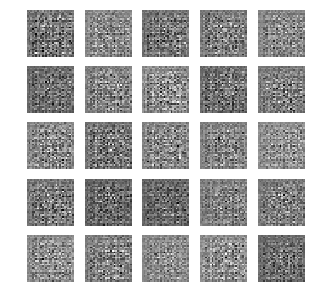

Epoch: 1, time elapse for current epoch 68.39861488342285


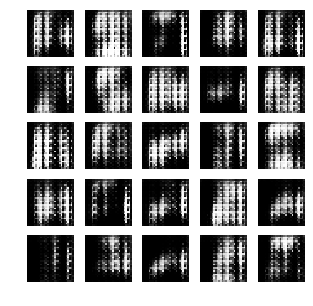

Epoch: 2, time elapse for current epoch 66.88758563995361


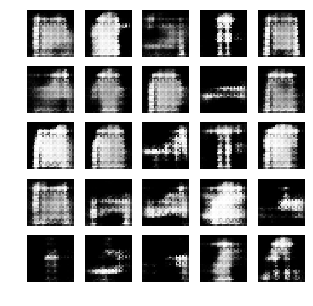

Epoch: 3, time elapse for current epoch 67.3745608329773


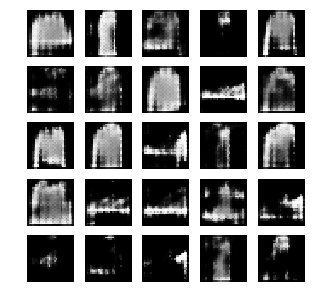

Epoch: 4, time elapse for current epoch 66.43394374847412


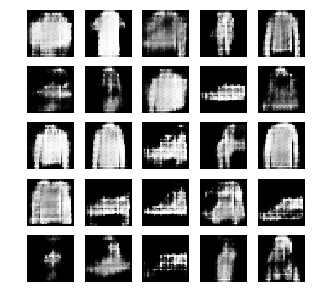

Epoch: 5, time elapse for current epoch 67.65481996536255


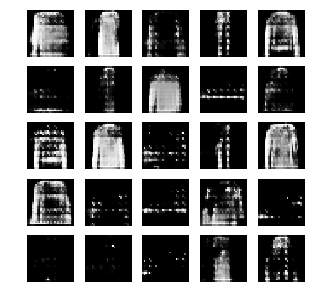

Epoch: 6, time elapse for current epoch 63.418989419937134


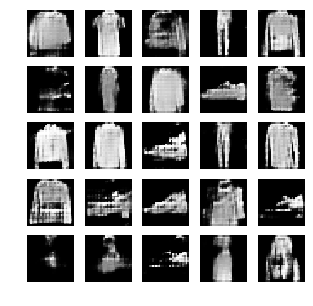

Epoch: 7, time elapse for current epoch 67.36910676956177


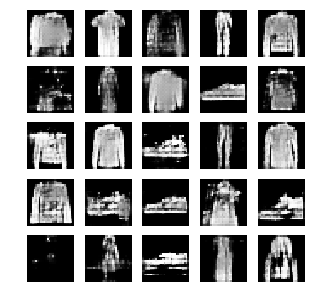

Epoch: 8, time elapse for current epoch 63.776695251464844


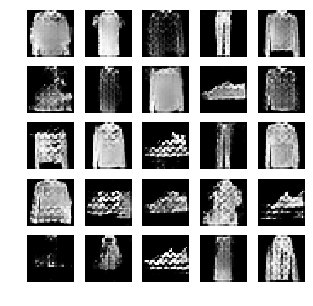

Epoch: 9, time elapse for current epoch 63.16590905189514


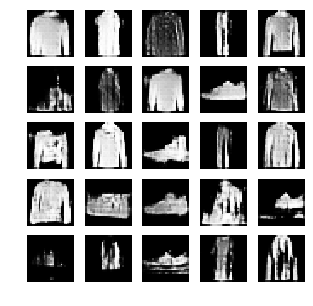

Epoch: 10, time elapse for current epoch 64.0589952468872


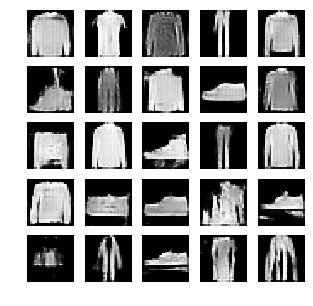

In [59]:
generate_and_save_images_gan(generator, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x, _ in train_ds_gan:
    disc_gradients, gen_gradients = compute_gradients_gan(discriminator, generator, train_x)
    apply_gradients(discriminator_optimizer, disc_gradients, discriminator.trainable_variables)
    apply_gradients(generator_optimizer, gen_gradients, generator.trainable_variables)

  end_time = time.time()

  if epoch % 1 == 0:
    print('Epoch: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    end_time - start_time))
    generate_and_save_images_gan(
        generator, epoch, random_vector_for_generation)

### Q2-2 (optional). `VAE` vs `GAN`

생성된 이미지 중 어느 것이 더 진짜 이미지에 가까운지 비교해보세요.
두 모델의 크기 (파라미터 개수)가 같다면, 둘 중 어느 것이 좋을까요? optimizer를 변경하거나, training epoch을 늘이거나 줄이면 어떤 양상을 보이는지 확인해보세요. latent variable의 dimension을 변경해보는 것도 좋습니다.

In [27]:
latent_dim = 50
epochs = 10
num_examples_to_generate = 25

In [28]:
inference_net = tf.keras.Sequential(
      [
        ##### 여기에 코드를 작성하세요 #####
      ]
    )
generative_net = tf.keras.Sequential(
        [
        ##### 여기에 코드를 작성하세요 #####
        ]
    )
print("===== Encoder =====")
inference_net.summary()
print("===== Decoder =====")
generative_net.summary()

===== Encoder =====


ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = inference_net
    self.generative_net = generative_net

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

  def reparameterize(self, mean, logvar):
    """Reparameterization trick"""
    ##### 여기에 코드를 작성하세요 #####
    eps = tf.random.normal(shape=mean.shape)
    z = eps * tf.exp(logvar * .5) + mean
    return z

In [29]:
# generation quality 향상을 보기 위한 random vector constant.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

# model과 optimizer 선언
model = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

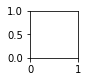

In [30]:
generate_and_save_images(model, 0, random_vector_for_generation)

#학습 시작
for epoch in range(1, epochs + 1):
  start_time = time.time()
  # epoch 시작
  for train_x, _ in train_ds_vae:
    gradients, loss = compute_gradients(model, train_x)
    apply_gradients(optimizer, gradients, model.trainable_variables)
  end_time = time.time()
  # epoch 끝

  if epoch % 1 == 0:
    # test set에서의 ELBO (-loss) 값 확인
    loss = tf.keras.metrics.Mean()
    for test_x, _ in test_ds_vae:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)